In [1]:
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error

In [2]:
class ProcessingData:
    
    def __init__(self,filepath):
        with open(filepath, 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            self.data = u.load()

    def fix_data(self, interval):
        """Fixes up the data. Makes sure we count two stage as single stage actions, don't count float actions,
        converts action duration and dt to floats, fill's nan's in action_duration and drops all datapoints which
        don't have dt equal to interval.
        :param data:
        :param interval: float:minutes"""
        def f(x):
            if x == 0:
                return 0
            elif x == 2 or x == 5:
                return 2
            elif x ==1 or x == 3:
                return 1

        def h(x):
            if x == 1:
                return 1
            else:
                return 0

        def c(x):
            if x == 2:
                return 1
            else:
                return 0

        self.data["action"] = self.data["action"].map(f)
        self.data['action_heating'] = self.data["action"].map(h)
        self.data['action_cooling'] = self.data['action'].map(c)

        #print self.data.head()

        return self.data, self.data[self.data["dt"] == interval]
    
    def filter_data(self):
        self.data = self.data.drop(['dt', 'action', 'previous_action', 'action_duration', \
                                    'zone_temperatureHVAC_Zone_Shelter_Corridor'], axis=1)
        return self.data
    
    def drop_nan(self):
        self.data = self.data.dropna()
        return self.data


In [3]:
training = ProcessingData("../../Data/avenal-animal-shelter_training_data.pkl")
training_data = training.fix_data(5)
training_data = training.filter_data()
training_data = training.drop_nan()
training_data.head()

,t_next,t_in,t_out,occ,action_heating,action_cooling
time,,,,,,
2018-04-18 23:16:42+00:00,69.5,69.483333,66.499700,0.0,0,0
2018-04-18 23:21:42+00:00,69.5,69.500000,66.499700,0.0,0,0
2018-04-18 23:26:42+00:00,69.5,69.500000,66.520546,0.0,0,0
2018-04-18 23:31:42+00:00,69.4,69.500000,66.583083,0.0,0,0
2018-04-18 23:36:42+00:00,69.5,69.400000,66.666466,0.0,0,0


In [4]:
testing = ProcessingData("../../Data/avenal-animal-shelter_test_data.pkl")
testing_data = testing.fix_data(5)
testing_data = testing.filter_data()
testing_data = testing.drop_nan()
testing_data.head()

,t_next,t_in,t_out,occ,action_heating,action_cooling
time,,,,,,
2018-03-20 00:00:00+00:00,72.8,72.8,67.778613,0.0,0,0
2018-03-20 00:05:00+00:00,73.0,72.8,67.807436,0.0,0,0
2018-03-20 00:10:00+00:00,73.0,73.0,67.835998,0.0,0,0
2018-03-20 00:15:00+00:00,73.0,73.0,67.864038,0.0,0,0
2018-03-20 00:20:00+00:00,73.0,73.0,67.891817,0.0,0,0


In [5]:
train_y = training_data['t_next']
train_X = training_data.drop(['t_next'], axis=1)
train_X.head()

,t_in,t_out,occ,action_heating,action_cooling
time,,,,,
2018-04-18 23:16:42+00:00,69.483333,66.499700,0.0,0,0
2018-04-18 23:21:42+00:00,69.500000,66.499700,0.0,0,0
2018-04-18 23:26:42+00:00,69.500000,66.520546,0.0,0,0
2018-04-18 23:31:42+00:00,69.500000,66.583083,0.0,0,0
2018-04-18 23:36:42+00:00,69.400000,66.666466,0.0,0,0


In [6]:
test_y = testing_data['t_next']
test_X = testing_data.drop(['t_next'], axis=1)
test_X.head()

,t_in,t_out,occ,action_heating,action_cooling
time,,,,,
2018-03-20 00:00:00+00:00,72.8,67.778613,0.0,0,0
2018-03-20 00:05:00+00:00,72.8,67.807436,0.0,0,0
2018-03-20 00:10:00+00:00,73.0,67.835998,0.0,0,0
2018-03-20 00:15:00+00:00,73.0,67.864038,0.0,0,0
2018-03-20 00:20:00+00:00,73.0,67.891817,0.0,0,0


In [7]:
from sklearn.linear_model import Ridge

ridge_clf = Ridge(alpha=1.0)
ridge_clf.fit(train_X, train_y)
test_pred = ridge_clf.predict(test_X)

In [8]:
rmse = sqrt(mean_squared_error(test_y,test_pred))
rmse

0.8619931664638767

In [9]:
def forecasting(test_X, test_y, start_time, duration, linearModel):
    predictions_i = []
    errs_i = []
    curr_time = start_time
    end_time = start_time + datetime.timedelta(minutes=duration)
    while curr_time <= end_time:
        if curr_time not in test_X.index:
            #print("Not present")
            return None
        input_x = test_X.loc[curr_time].copy()
        if predictions_i:
            input_x['t_in'] = predictions_i[-1]
        y = linearModel.predict([input_x])
        predictions_i.append(y[0])
        errs_i.append(test_y.loc[curr_time] - y[0])
        curr_time = curr_time + datetime.timedelta(minutes=5)
    #print(predictions_i)
    #print(errs_i)
    return errs_i

In [11]:
predictions = []
errs = []
startSamples = test_X.sample(n=800)
startList = startSamples.index
duration = 60 * 7
for start in startList:
    errs_i = forecasting(test_X, test_y, start, duration, ridge_clf)
    #predictions.append(pd.Series(index=range(len(predictions_i)), data=predictions_i))
    if errs_i:
        errs.append(pd.Series(index=range(len(errs_i)), data=errs_i))
#print(predictions)
#print(errs)

[0.11266308446067788, 0.18746904912770385, 0.2650200082510908, 0.33342681163039145, 0.3956374178076978, 0.4660297525398998, 0.5211483931499787, 0.5861301017979029, 0.634281198936261, 0.6736166258788769, 0.7218759592733617, 0.7626595002375232, 0.8027386195100457, 0.8591507071373641, 0.9040130481553221, 0.9419811987912566, 0.9840671487972921, 1.027983661116485, 1.067580299519768, 1.0879597839560915, 1.1116418751788208, 1.148730877377101, 1.1722746962936583, 1.1884116928979485, 1.2083679153384828, 1.2301104214818381, 1.251914127934595, 1.2816305868552713, 1.3219249814259904, 1.3643208819258565, 1.3884129629384516, 1.413792348644726, 1.4432590806049963, 1.4745183627538738, 1.5004822957094999, 1.524212145096061, 1.5525326086404359, 1.577433906657253, 1.597919191298265, 1.6264167005655954, 1.658221728960793, 1.6872588138178306, 1.7059454297921932, 1.724620022276344, 1.7510154893296237, 1.783950880693611, 1.8121964934994588, 1.8464449987762759, 1.8790642529527835, 1.8981211759615606, 1.925114

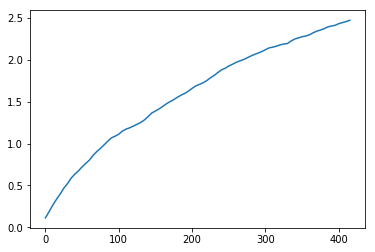

In [12]:
final_errors = []
for i in range(int(duration/5)):
    ei = np.array([])
    for e in errs:
        ei = np.append(ei, e.loc[i]*e.loc[i])
    final_errors.append(sqrt(np.mean(ei)))
#final_errors = pd.Series(index=range(len(final_errors)), data = final_errors)
print(final_errors)
timesteps = [x*5 for x in range(len(final_errors))]
plt.plot(timesteps,final_errors)
plt.show()